https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting

In [1]:
import numpy as np 
import pandas as pd 

Import data

In [3]:
df = pd.read_csv('dataset.csv')

df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


1. First, let's check if the series is stationary using the Augmented Dickey Fuller test (ADF Test), from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.
3. The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.
5. So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [4]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


Since p-value(1.00) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

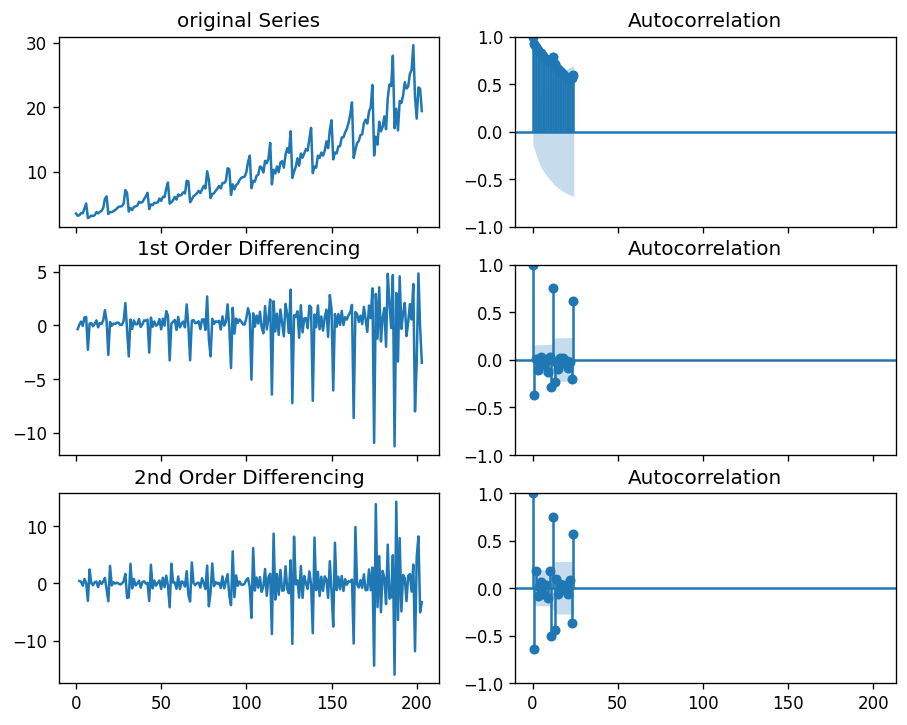

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0,0].set_title('original Series')
plot_acf(df.value, ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

# 2nd and 3rd order differencing hasthe same auto correlation

plt.show()

### Find the order of the AR term (p)
Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. This way, we will know if that lag is needed in the AR term or not.

Let's find the number of AR terms. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

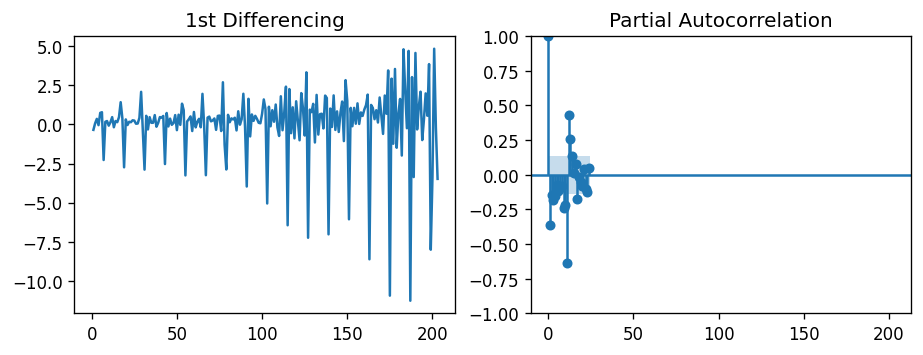

In [13]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

### Find the order of the MA term (q)
- Just like how we looked at the PACF plot for the number of AR terms, we will look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
- The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
- Let’s see the autocorrelation plot of the differenced series.

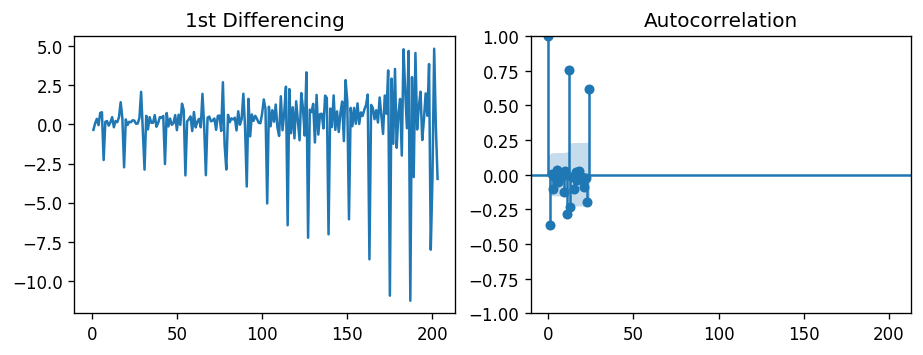

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

We can see that couple of lags are well above the significance line. So, we will fix q as 2. If there is any doubt, we will go with the simpler model that sufficiently explains the Y.

- It may happen that the time series is slightly under differenced. Differencing it one more time makes it slightly over-differenced.
- If the series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, we will try adding an additional MA term.

### Build the ARIMA Model

In [19]:
from statsmodels.tsa.arima.model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Sun, 15 Dec 2024   AIC                            857.140
Time:                        11:20:00   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

- The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

- The coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

- So, we will rebuild the model without the MA2 term.

In [21]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Sun, 15 Dec 2024   AIC                            855.524
Time:                        11:25:30   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

- The model AIC has slightly reduced, which is good. The p-values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

- Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

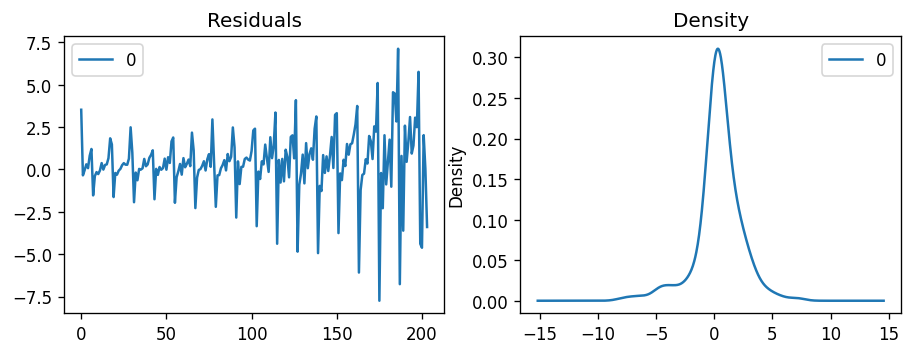

In [22]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

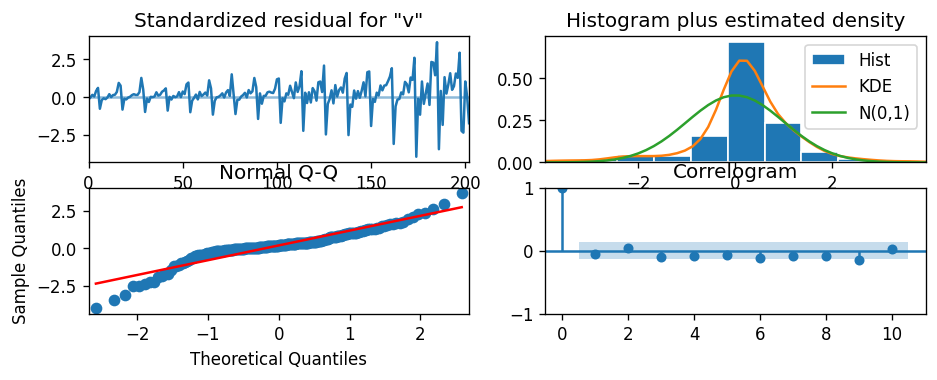

In [26]:
# ModelDiagnostics
model_fit.plot_diagnostics()
plt.show()

# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

### Find the optimal ARIMA model using Out-of-Time Cross validation
In Out-of-Time cross-validation, we move backwards in time and forecast into the future to as many steps we took back. Then we compare the forecast against the actuals.

To do so, we will create the training and testing dataset by splitting the time series into 2 contiguous parts in a reasonable proportion based on time frequency of series.

In [27]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

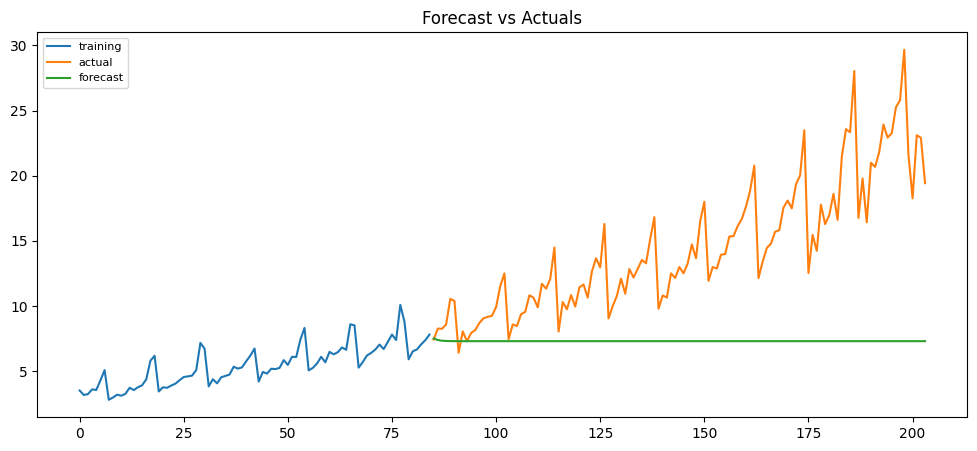

In [41]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(119)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


- From the above chart, the ARIMA(1,1,1) model seems to predict a correct forecast. The actual observed values lie within the 95% confidence band.

- But, we can see that the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve.

- So, in this case, we should increase the order of differencing to two (d=2) and iteratively increase p and q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

- While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -116.886
Date:                Sun, 15 Dec 2024   AIC                            243.771
Time:                        11:49:22   BIC                            255.865
Sample:                             0   HQIC                           248.630
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2206      0.194     -1.140      0.254      -0.600       0.159
ar.L2         -0.3435      0.141     -2.443      0.015      -0.619      -0.068
ar.L3         -0.0937      0.252     -0.371      0.7

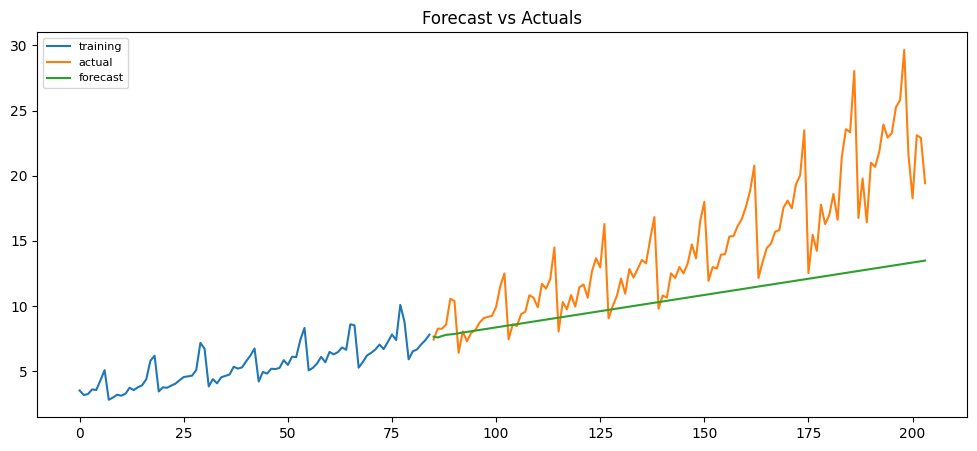

In [42]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc = fitted.forecast(119)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 245 from 843 which is good. Mostly, the p-values of the X terms are less than < 0.05, which is great. So overall this model is much better.

### Accuracy Metrics for Time Series Forecast
Typically, we will use three accuracy metrices:-

1. MAPE
2. Correlation and
3. Min-Max Error

The above three are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series.

In [44]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [48]:
print(type(np.array(fc)))
print(type(test.values))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [49]:
forecast_accuracy(np.array(fc), test.values)

{'mape': 0.23266730758428028,
 'me': -3.8806935175588304,
 'mae': 3.9817272538152197,
 'mpe': -0.21930675993681445,
 'rmse': 5.307192335961922,
 'acf1': 0.6960304622821869,
 'corr': 0.8736885007720085,
 'minmax': 0.2318683237889898}

Around 23.26% MAPE implies the model is about 76.74% accurate in predicting the next 15 observations. Now we know how to build an ARIMA model manually.

But, we should also know how to automate the best model selection process. So, we will discuss it next.